In [ ]:
!nvidia-smi

Wed Jan 21 04:44:10 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
!pip install segmentation-models-pytorch -q
!pip install albumentations -q

import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.6 MB/s eta 0:00:00
✅ Using device: cuda


In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
import os
import shutil
import subprocess
import time
from IPython.display import clear_output

# 기존 폴더 삭제
if os.path.exists('/content/dataset'):
    shutil.rmtree('/content/dataset')
    print("🗑️ 기존 폴더 삭제 완료")

drive_path = '/content/drive/MyDrive'
dataset_path = '/content/dataset'
os.makedirs(f'{dataset_path}/train', exist_ok=True)
os.makedirs(f'{dataset_path}/val', exist_ok=True)

# Train 압축 해제 (백그라운드)
print("📦 Train 압축 해제 시작...")
process = subprocess.Popen(
    f'unzip -o "{drive_path}/train_dataset.zip" -d "{dataset_path}/train"',
    shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
)

# 진행 상황 모니터링 (예상 파일 수: ~17,800개 * 2 = ~35,600개)
expected_files = 35600
while process.poll() is None:
    try:
        count = sum(len(files) for _, _, files in os.walk(f'{dataset_path}/train'))
        progress = min(count / expected_files * 100, 99)
        print(f"\r📦 Train 진행: {count:,}개 파일 ({progress:.1f}%)", end='', flush=True)
    except:
        pass
    time.sleep(2)

print(f"\n✅ Train 완료!")

# Val 압축 해제 (백그라운드)
print("\n📦 Val 압축 해제 시작...")
process = subprocess.Popen(
    f'unzip -o "{drive_path}/val_dataset.zip" -d "{dataset_path}/val"',
    shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
)

expected_files_val = 9000
while process.poll() is None:
    try:
        count = sum(len(files) for _, _, files in os.walk(f'{dataset_path}/val'))
        progress = min(count / expected_files_val * 100, 99)
        print(f"\r📦 Val 진행: {count:,}개 파일 ({progress:.1f}%)", end='', flush=True)
    except:
        pass
    time.sleep(2)

print(f"\n✅ Val 완료!")

# 최종 확인
print("\n📁 결과 확인:")
print(f"Train: {os.listdir(f'{dataset_path}/train')}")
print(f"Val: {os.listdir(f'{dataset_path}/val')}")

📦 Train 압축 해제 시작...
📦 Train 진행: 23,708개 파일 (66.6%)
✅ Train 완료!

📦 Val 압축 해제 시작...
📦 Val 진행: 4,360개 파일 (48.4%)
✅ Val 완료!

📁 결과 확인:
Train: ['content']
Val: ['content']


In [ ]:
import os

dataset_path = '/content/dataset'

print("="*50)
print("📁 압축 해제 결과 확인")
print("="*50)

# 1. 기본 폴더 확인
print("\n[1] 기본 폴더 구조:")
print(f"   dataset: {os.listdir(dataset_path)}")

# 2. Train 경로 확인
train_paths = [
    '/content/dataset/train',
    '/content/dataset/train/content',
    '/content/dataset/train/content/split_dataset',
    '/content/dataset/train/content/split_dataset/train'
]

print("\n[2] Train 경로 탐색:")
train_base = None
for path in train_paths:
    if os.path.exists(path):
        contents = os.listdir(path)
        print(f"   ✅ {path}")
        print(f"      내용: {contents[:5]}")
        if 'images' in contents and 'labels' in contents:
            train_base = path
            print(f"      🎯 Train 데이터 발견!")

# 3. Val 경로 확인
val_paths = [
    '/content/dataset/val',
    '/content/dataset/val/content',
    '/content/dataset/val/content/split_dataset',
    '/content/dataset/val/content/split_dataset/val'
]

print("\n[3] Val 경로 탐색:")
val_base = None
for path in val_paths:
    if os.path.exists(path):
        contents = os.listdir(path)
        print(f"   ✅ {path}")
        print(f"      내용: {contents[:5]}")
        if 'images' in contents and 'labels' in contents:
            val_base = path
            print(f"      🎯 Val 데이터 발견!")

# 4. 최종 확인
print("\n" + "="*50)
print("📊 최종 확인")
print("="*50)

if train_base and val_base:
    train_images = len(os.listdir(f'{train_base}/images'))
    val_images = len(os.listdir(f'{val_base}/images'))

    print(f"\n✅ Train 경로: {train_base}")
    print(f"   이미지 수: {train_images}개")

    print(f"\n✅ Val 경로: {val_base}")
    print(f"   이미지 수: {val_images}개")

    print(f"\n🎉 압축 해제 성공!")
    print(f"\n[다음 단계에서 사용할 경로]")
    print(f"   train_base = '{train_base}'")
    print(f"   val_base = '{val_base}'")
else:
    print("\n❌ 데이터 경로를 찾을 수 없습니다!")

📁 압축 해제 결과 확인

[1] 기본 폴더 구조:
   dataset: ['val', 'train']

[2] Train 경로 탐색:
   ✅ /content/dataset/train
      내용: ['content']
   ✅ /content/dataset/train/content
      내용: ['split_dataset']
   ✅ /content/dataset/train/content/split_dataset
      내용: ['train']
   ✅ /content/dataset/train/content/split_dataset/train
      내용: ['labels', 'images']
      🎯 Train 데이터 발견!

[3] Val 경로 탐색:
   ✅ /content/dataset/val
      내용: ['content']
   ✅ /content/dataset/val/content
      내용: ['split_dataset']
   ✅ /content/dataset/val/content/split_dataset
      내용: ['val']
   ✅ /content/dataset/val/content/split_dataset/val
      내용: ['labels', 'images']
      🎯 Val 데이터 발견!

📊 최종 확인

✅ Train 경로: /content/dataset/train/content/split_dataset/train
   이미지 수: 17797개

✅ Val 경로: /content/dataset/val/content/split_dataset/val
   이미지 수: 4450개

🎉 압축 해제 성공!

[다음 단계에서 사용할 경로]
   train_base = '/content/dataset/train/content/split_dataset/train'
   val_base = '/content/dataset/val/content/split_dataset/val'


In [ ]:
import numpy as np
import cv2
import json
import os
from tqdm import tqdm

CLASS_MAP = {
    'Background': 0,
    'Pollution': 1,
    'Damaged': 2,
    'Outline': 3
}

def create_semantic_mask(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    width = data['image_info']['width']
    height = data['image_info']['height']
    mask = np.zeros((height, width), dtype=np.uint8)

    outline = data.get('swelling', {}).get('battery_outline', [])
    if outline:
        points = np.array(outline, dtype=np.float32).reshape(-1, 2).astype(np.int32)
        cv2.fillPoly(mask, [points], color=CLASS_MAP['Outline'])

    defects = data.get('defects')
    if defects and isinstance(defects, list):
        for defect in defects:
            name = defect.get('name')
            points = defect.get('points', [])
            if name in CLASS_MAP and points:
                pts = np.array(points, dtype=np.float32).reshape(-1, 2).astype(np.int32)
                cv2.fillPoly(mask, [pts], color=CLASS_MAP[name])

    return mask

def generate_semantic_masks(label_path, mask_save_path):
    os.makedirs(mask_save_path, exist_ok=True)
    json_files = [f for f in os.listdir(label_path) if f.endswith('.json')]

    for json_file in tqdm(json_files):
        json_full_path = os.path.join(label_path, json_file)
        mask = create_semantic_mask(json_full_path)
        mask_filename = json_file.replace('.json', '_mask.png')
        cv2.imwrite(os.path.join(mask_save_path, mask_filename), mask)

    return len(json_files)

# 경로 설정
train_base = '/content/dataset/train/content/split_dataset/train'
val_base = '/content/dataset/val/content/split_dataset/val'

# Mask 생성
print("📦 Train Semantic Mask 생성 중...")
generate_semantic_masks(f'{train_base}/labels', f'{train_base}/semantic_masks')
print("✅ Train Mask 완료!")

print("📦 Val Semantic Mask 생성 중...")
generate_semantic_masks(f'{val_base}/labels', f'{val_base}/semantic_masks')
print("✅ Val Mask 완료!")

📦 Train Semantic Mask 생성 중...


100%|██████████| 17797/17797 [02:12<00:00, 133.94it/s]


✅ Train Mask 완료!
📦 Val Semantic Mask 생성 중...


100%|██████████| 4450/4450 [00:33<00:00, 134.08it/s]

✅ Val Mask 완료!


In [ ]:
!nvidia-smi

Wed Jan 21 05:00:20 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
#데이터셋 클래스 정의

class BatteryDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, img_size=512):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_size = img_size

        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

        valid_images = []
        for img_name in self.images:
            mask_name = img_name.replace('.png', '_mask.png')
            if os.path.exists(os.path.join(mask_dir, mask_name)):
                valid_images.append(img_name)

        self.images = valid_images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask_name = img_name.replace('.png', '_mask.png')
        mask_path = os.path.join(self.mask_dir, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (self.img_size, self.img_size))
        mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.long()

print("✅ Dataset 클래스 정의 완료!")

✅ Dataset 클래스 정의 완료!


In [ ]:
#5단계 : Dataset & DataLoader 생성

# Augmentation 정의
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# 경로 설정
train_base = '/content/dataset/train/content/split_dataset/train'
val_base = '/content/dataset/val/content/split_dataset/val'

# Dataset 생성
train_dataset = BatteryDataset(f'{train_base}/images', f'{train_base}/semantic_masks', transform=train_transform, img_size=512)
val_dataset = BatteryDataset(f'{val_base}/images', f'{val_base}/semantic_masks', transform=val_transform, img_size=512)

# ⭐ 안정적인 DataLoader 설정
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2
)

# ⭐ 설정 확인
print("\n" + "="*50)
print("⭐ 설정 확인 (학습 전 필수 체크!)")
print("="*50)
print(f"Train 샘플 수: {len(train_dataset)}")
print(f"Val 샘플 수: {len(val_dataset)}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Train 배치 수: {len(train_loader)}")
print(f"Val 배치 수: {len(val_loader)}")
print(f"num_workers: 4")
print("="*50)

if len(train_loader) > 1000 and len(train_loader) < 1200:
    print("✅ 설정 정상! 학습 진행 가능!")
else:
    print(f"⚠️ 배치 수 확인 필요 (예상: ~1112)")


⭐ 설정 확인 (학습 전 필수 체크!)
Train 샘플 수: 17797
Val 샘플 수: 4450
Batch Size: 16
Train 배치 수: 1113
Val 배치 수: 279
num_workers: 4
✅ 설정 정상! 학습 진행 가능!


In [ ]:
#6단계 :  모델 & Loss & Optimizer

# 모델 생성
model = smp.DeepLabV3Plus(
    encoder_name="timm-mobilenetv3_large_100",
    encoder_weights="imagenet",
    in_channels=3,
    classes=4
)
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("✅ 모델 & Loss & Optimizer 설정 완료!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

✅ 모델 & Loss & Optimizer 설정 완료!


In [ ]:
#7: 학습 함수 정의

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, masks in tqdm(loader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    return total_loss / len(loader)

def calculate_miou(model, loader, device, num_classes=4):
    model.eval()
    iou_per_class = np.zeros(num_classes)
    count_per_class = np.zeros(num_classes)

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.numpy()

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            for cls in range(num_classes):
                intersection = np.sum((preds == cls) & (masks == cls))
                union = np.sum((preds == cls) | (masks == cls))

                if union > 0:
                    iou_per_class[cls] += intersection / union
                    count_per_class[cls] += 1

    iou_per_class = np.divide(iou_per_class, count_per_class, where=count_per_class!=0)
    miou = np.mean(iou_per_class[count_per_class > 0])

    return miou, iou_per_class

print("✅ 학습 함수 정의 완료!")

✅ 학습 함수 정의 완료!


In [ ]:
#8: 학습 실행

NUM_EPOCHS = 30
BEST_LOSS = float('inf')

history = {'train_loss': [], 'val_loss': [], 'miou': []}

save_path = '/content/drive/MyDrive/MyDataset'
os.makedirs(save_path, exist_ok=True)

print("🚀 A100 최적화 학습 시작!")
print(f"Epochs: {NUM_EPOCHS}, Batch: {BATCH_SIZE}, Image Size: 512x512, Classes: 4")
print(f"Train 배치 수: {len(train_loader)}, Val 배치 수: {len(val_loader)}\n")

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*50}")

# ⭐ 첫 에폭에서 GPU 사용량 확인
    if epoch == 0:
        print("\n📊 GPU 상태:")
        !nvidia-smi --query-gpu=utilization.gpu,memory.used,memory.total --format=csv

    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)

    if (epoch + 1) % 5 == 0:
        miou, iou_per_class = calculate_miou(model, val_loader, device)
        history['miou'].append(miou)
        print(f"\n📊 mIoU: {miou:.4f}")
        print(f"   Background: {iou_per_class[0]:.4f}")
        print(f"   Pollution:  {iou_per_class[1]:.4f}")
        print(f"   Damaged:    {iou_per_class[2]:.4f}")
        print(f"   Outline:    {iou_per_class[3]:.4f}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f"\nTrain Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")

    scheduler.step(val_loss)

    if val_loss < BEST_LOSS:
        BEST_LOSS = val_loss
        torch.save(model.state_dict(), f'{save_path}/best_model.pth')
        print("💾 Best 모델 저장!")

torch.save(model.state_dict(), f'{save_path}/last_model.pth')
print("\n🎉 학습 완료!")

🚀 A100 최적화 학습 시작!
Epochs: 30, Batch: 16, Image Size: 512x512, Classes: 4
Train 배치 수: 1113, Val 배치 수: 279


Epoch 1/30

📊 GPU 상태:
utilization.gpu [%], memory.used [MiB], memory.total [MiB]
0 %, 461 MiB, 40960 MiB


Validation: 100%|██████████| 279/279 [01:01<00:00,  4.53it/s]



Train Loss: 0.0842
Val Loss:   0.0198
💾 Best 모델 저장!

Epoch 2/30


Validation: 100%|██████████| 279/279 [01:02<00:00,  4.48it/s]



Train Loss: 0.0181
Val Loss:   0.0153
💾 Best 모델 저장!

Epoch 3/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.59it/s]



Train Loss: 0.0147
Val Loss:   0.0132
💾 Best 모델 저장!

Epoch 4/30


Validation: 100%|██████████| 279/279 [01:01<00:00,  4.56it/s]



Train Loss: 0.0131
Val Loss:   0.0120
💾 Best 모델 저장!

Epoch 5/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.58it/s]



📊 mIoU: 0.6229
   Background: 0.9984
   Pollution:  0.4385
   Damaged:    0.0890
   Outline:    0.9659

Train Loss: 0.0122
Val Loss:   0.0115
💾 Best 모델 저장!

Epoch 6/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.58it/s]



Train Loss: 0.0115
Val Loss:   0.0108
💾 Best 모델 저장!

Epoch 7/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.58it/s]



Train Loss: 0.0109
Val Loss:   0.0102
💾 Best 모델 저장!

Epoch 8/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.58it/s]



Train Loss: 0.0105
Val Loss:   0.0102

Epoch 9/30


Validation: 100%|██████████| 279/279 [01:01<00:00,  4.57it/s]



Train Loss: 0.0100
Val Loss:   0.0096
💾 Best 모델 저장!

Epoch 10/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.58it/s]



📊 mIoU: 0.6674
   Background: 0.9987
   Pollution:  0.5395
   Damaged:    0.1602
   Outline:    0.9711

Train Loss: 0.0098
Val Loss:   0.0094
💾 Best 모델 저장!

Epoch 11/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.62it/s]



Train Loss: 0.0095
Val Loss:   0.0092
💾 Best 모델 저장!

Epoch 12/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.65it/s]



Train Loss: 0.0092
Val Loss:   0.0090
💾 Best 모델 저장!

Epoch 13/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.61it/s]



Train Loss: 0.0090
Val Loss:   0.0087
💾 Best 모델 저장!

Epoch 14/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.62it/s]



Train Loss: 0.0089
Val Loss:   0.0087
💾 Best 모델 저장!

Epoch 15/30


Training: 100%|██████████| 1113/1113 [04:07<00:00,  4.50it/s]

Validation: 100%|██████████| 279/279 [01:00<00:00,  4.63it/s]




📊 mIoU: 0.6775
   Background: 0.9988
   Pollution:  0.5570
   Damaged:    0.1806
   Outline:    0.9735

Train Loss: 0.0087
Val Loss:   0.0085
💾 Best 모델 저장!

Epoch 16/30

📊 mIoU: 0.6775
   Background: 0.9988
   Pollution:  0.5570
   Damaged:    0.1806
   Outline:    0.9735

Train Loss: 0.0087
Val Loss:   0.0085
💾 Best 모델 저장!

Epoch 16/30


Training: 100%|██████████| 1113/1113 [04:07<00:00,  4.50it/s]

Validation: 100%|██████████| 279/279 [01:00<00:00,  4.64it/s]



Train Loss: 0.0085
Val Loss:   0.0084
💾 Best 모델 저장!

Epoch 17/30



Train Loss: 0.0085
Val Loss:   0.0084
💾 Best 모델 저장!

Epoch 17/30


Training: 100%|██████████| 1113/1113 [04:07<00:00,  4.50it/s]

Validation: 100%|██████████| 279/279 [01:00<00:00,  4.62it/s]




Train Loss: 0.0083
Val Loss:   0.0083
💾 Best 모델 저장!

Epoch 18/30


Training:   0%|          | 0/1113 [00:00<?, ?it/s]


Train Loss: 0.0083
Val Loss:   0.0083
💾 Best 모델 저장!

Epoch 18/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.63it/s]




Train Loss: 0.0081
Val Loss:   0.0082
💾 Best 모델 저장!

Epoch 19/30


Training:   0%|          | 0/1113 [00:00<?, ?it/s]


Train Loss: 0.0081
Val Loss:   0.0082
💾 Best 모델 저장!

Epoch 19/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.63it/s]



Train Loss: 0.0080
Val Loss:   0.0081
💾 Best 모델 저장!

Epoch 20/30



Training:   0%|          | 0/1113 [00:00<?, ?it/s]


Train Loss: 0.0080
Val Loss:   0.0081
💾 Best 모델 저장!

Epoch 20/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.61it/s]




📊 mIoU: 0.6967
   Background: 0.9988
   Pollution:  0.6003
   Damaged:    0.2132
   Outline:    0.9744

Train Loss: 0.0079
Val Loss:   0.0080
💾 Best 모델 저장!

Epoch 21/30

📊 mIoU: 0.6967
   Background: 0.9988
   Pollution:  0.6003
   Damaged:    0.2132
   Outline:    0.9744

Train Loss: 0.0079
Val Loss:   0.0080
💾 Best 모델 저장!

Epoch 21/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.59it/s]



Train Loss: 0.0078
Val Loss:   0.0079
💾 Best 모델 저장!

Epoch 22/30



Training:   0%|          | 0/1113 [00:00<?, ?it/s]


Train Loss: 0.0078
Val Loss:   0.0079
💾 Best 모델 저장!

Epoch 22/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.63it/s]



Train Loss: 0.0076
Val Loss:   0.0078
💾 Best 모델 저장!

Epoch 23/30



Training:   0%|          | 0/1113 [00:00<?, ?it/s]


Train Loss: 0.0076
Val Loss:   0.0078
💾 Best 모델 저장!

Epoch 23/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.61it/s]



Train Loss: 0.0075
Val Loss:   0.0077
💾 Best 모델 저장!

Epoch 24/30



Training:   0%|          | 0/1113 [00:00<?, ?it/s]


Train Loss: 0.0075
Val Loss:   0.0077
💾 Best 모델 저장!

Epoch 24/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.64it/s]




Train Loss: 0.0075
Val Loss:   0.0076
💾 Best 모델 저장!

Epoch 25/30

Train Loss: 0.0075
Val Loss:   0.0076
💾 Best 모델 저장!

Epoch 25/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.62it/s]




📊 mIoU: 0.7011
   Background: 0.9989
   Pollution:  0.6082
   Damaged:    0.2215
   Outline:    0.9757

Train Loss: 0.0074
Val Loss:   0.0076
💾 Best 모델 저장!

Epoch 26/30


Training:   0%|          | 0/1113 [00:00<?, ?it/s]


📊 mIoU: 0.7011
   Background: 0.9989
   Pollution:  0.6082
   Damaged:    0.2215
   Outline:    0.9757

Train Loss: 0.0074
Val Loss:   0.0076
💾 Best 모델 저장!

Epoch 26/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.63it/s]



Train Loss: 0.0073
Val Loss:   0.0077

Epoch 27/30


Training:   0%|          | 0/1113 [00:00<?, ?it/s]



Train Loss: 0.0073
Val Loss:   0.0077

Epoch 27/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.63it/s]



Train Loss: 0.0072
Val Loss:   0.0075
💾 Best 모델 저장!

Epoch 28/30



Training:   0%|          | 0/1113 [00:00<?, ?it/s]


Train Loss: 0.0072
Val Loss:   0.0075
💾 Best 모델 저장!

Epoch 28/30


Validation: 100%|██████████| 279/279 [01:00<00:00,  4.64it/s]



Train Loss: 0.0072
Val Loss:   0.0075
💾 Best 모델 저장!

Epoch 29/30



Train Loss: 0.0072
Val Loss:   0.0075
💾 Best 모델 저장!

Epoch 29/30


Training: 100%|██████████| 1113/1113 [04:07<00:00,  4.49it/s]

Validation: 100%|██████████| 279/279 [01:00<00:00,  4.63it/s]




Train Loss: 0.0070
Val Loss:   0.0075
💾 Best 모델 저장!

Epoch 30/30

Train Loss: 0.0070
Val Loss:   0.0075
💾 Best 모델 저장!

Epoch 30/30


Training: 100%|██████████| 1113/1113 [04:06<00:00,  4.51it/s]

Validation: 100%|██████████| 279/279 [01:00<00:00,  4.63it/s]




📊 mIoU: 0.7095
   Background: 0.9988
   Pollution:  0.6208
   Damaged:    0.2422
   Outline:    0.9761

Train Loss: 0.0070
Val Loss:   0.0075

📊 mIoU: 0.7095
   Background: 0.9988
   Pollution:  0.6208
   Damaged:    0.2422
   Outline:    0.9761

Train Loss: 0.0070
Val Loss:   0.0075

🎉 학습 완료!

🎉 학습 완료!


In [ ]:
!nvidia-smi

Wed Jan 21 07:42:26 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             50W /  400W |    8377MiB /  40960MiB |      1%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# 학습 코드에 체크포인트 추가 (매 에폭 저장)
if val_loss < BEST_LOSS:
    BEST_LOSS = val_loss
    torch.save(model.state_dict(), f'{save_path}/best_model.pth')

# 매 에폭마다 저장 (끊겨도 이어서 가능)
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'history': history
}, f'{save_path}/checkpoint.pth')

In [ ]:
# 체크포인트 로드
checkpoint = torch.load(f'{save_path}/checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1
history = checkpoint['history']

print(f"✅ Epoch {start_epoch}부터 이어서 학습!")

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

# 연결 안되면
1. 드라이브에서 모델 확인
2. 저장된 모델로 평가/추론 가능
3. 필요하면 이어서 학습

In [ ]:
import os
save_path = '/content/drive/MyDrive/MyDataset'
print(os.listdir(save_path))

In [ ]:
# 저장된 모델 로드
model.load_state_dict(torch.load(f'{save_path}/best_model.pth'))
model.eval()
print("✅ Epoch 16 모델 로드 완료!")

# 시각화 + 저장


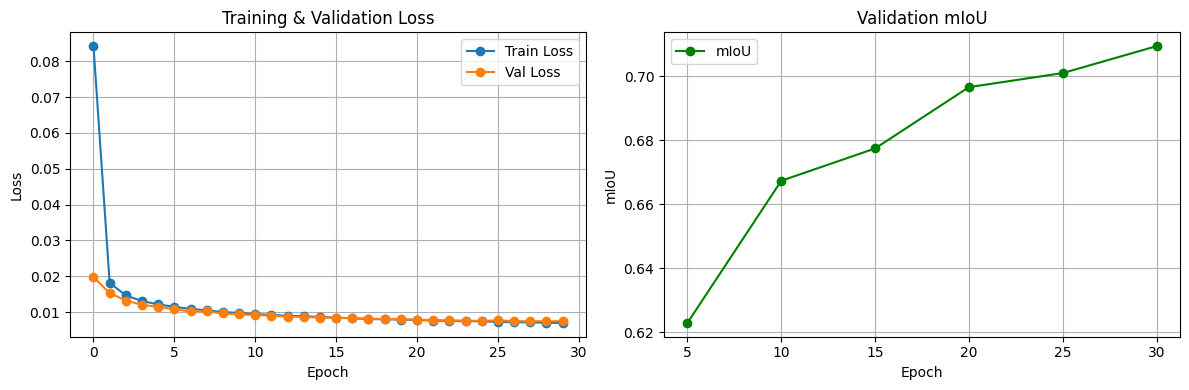

✅ 학습 곡선 저장: /content/drive/MyDrive/MyDataset/training_history.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
from tqdm import tqdm

# 저장 경로
save_path = '/content/drive/MyDrive/MyDataset'
os.makedirs(save_path, exist_ok=True)

# ===== 1. 학습 곡선 저장 =====
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
if history['miou']:
    epochs_miou = [5*(i+1) for i in range(len(history['miou']))]
    plt.plot(epochs_miou, history['miou'], 'o-', label='mIoU', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.title('Validation mIoU')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig(f'{save_path}/training_history.png', dpi=150)
plt.show()
print(f"✅ 학습 곡선 저장: {save_path}/training_history.png")

In [ ]:
# Best 모델 로드
model.load_state_dict(torch.load(f'{save_path}/best_model.pth'))
model.eval()

# 최종 mIoU 계산
print("📊 최종 성능 평가 중...")
miou, iou_per_class = calculate_miou(model, val_loader, device)

# 결과 출력
print("\n" + "="*50)
print("📊 최종 검증 결과")
print("="*50)
print(f"\n🎯 mIoU: {miou:.4f}")
print(f"\n클래스별 IoU:")
print(f"   Background: {iou_per_class[0]:.4f}")
print(f"   Pollution:  {iou_per_class[1]:.4f}")
print(f"   Damaged:    {iou_per_class[2]:.4f}")
print(f"   Outline:    {iou_per_class[3]:.4f}")

# 결과를 텍스트 파일로 저장
with open(f'{save_path}/evaluation_results.txt', 'w') as f:
    f.write("="*50 + "\n")
    f.write("DeepLabV3+ (MobileNetV3) 학습 결과\n")
    f.write("="*50 + "\n\n")
    f.write(f"[설정]\n")
    f.write(f"- Image Size: 512x512\n")
    f.write(f"- Batch Size: 8\n")
    f.write(f"- Epochs: 30\n")
    f.write(f"- Classes: 4\n\n")
    f.write(f"[최종 Loss]\n")
    f.write(f"- Train Loss: {history['train_loss'][-1]:.4f}\n")
    f.write(f"- Val Loss: {history['val_loss'][-1]:.4f}\n\n")
    f.write(f"[최종 mIoU]: {miou:.4f}\n\n")
    f.write(f"[클래스별 IoU]\n")
    f.write(f"- Background: {iou_per_class[0]:.4f}\n")
    f.write(f"- Pollution:  {iou_per_class[1]:.4f}\n")
    f.write(f"- Damaged:    {iou_per_class[2]:.4f}\n")
    f.write(f"- Outline:    {iou_per_class[3]:.4f}\n")

print(f"\n✅ 결과 저장: {save_path}/evaluation_results.txt")

📊 최종 성능 평가 중...

📊 최종 검증 결과

🎯 mIoU: 0.7104

클래스별 IoU:
   Background: 0.9989
   Pollution:  0.6245
   Damaged:    0.2423
   Outline:    0.9761

✅ 결과 저장: /content/drive/MyDrive/MyDataset/evaluation_results.txt


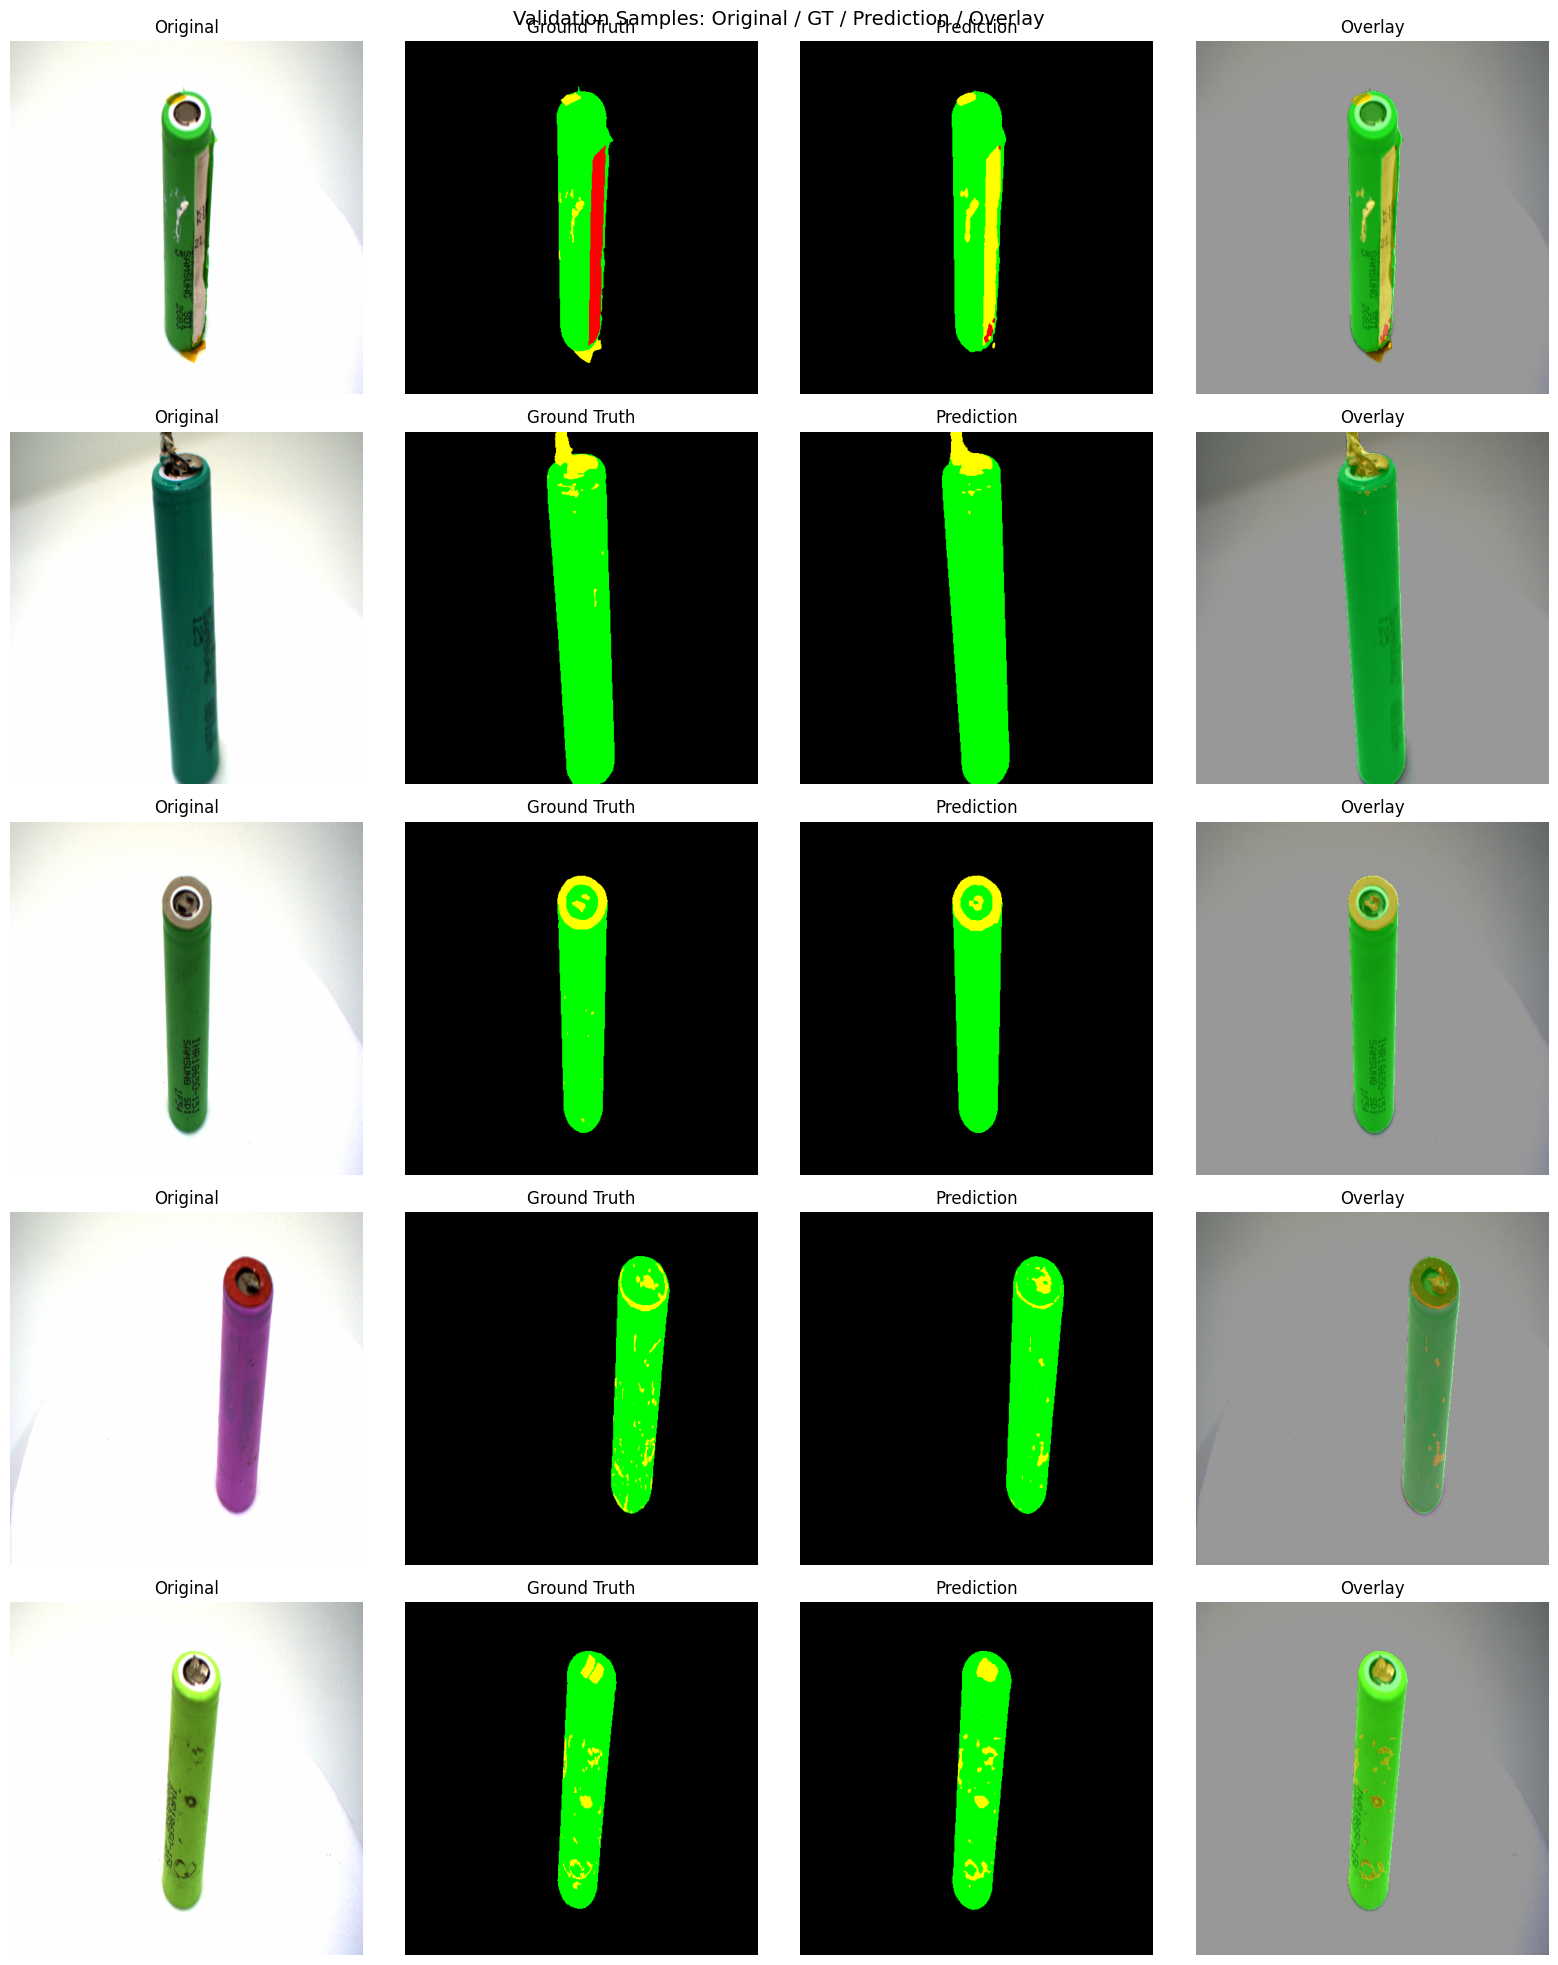

✅ 샘플 예측 저장: /content/drive/MyDrive/MyDataset/sample_predictions.png


In [ ]:
# 컬러맵 정의
COLORS = {
    0: [0, 0, 0],        # Background: 검정
    1: [255, 255, 0],    # Pollution: 노랑
    2: [255, 0, 0],      # Damaged: 빨강
    3: [0, 255, 0]       # Outline: 초록
}

def mask_to_color(mask):
    """마스크를 컬러 이미지로 변환"""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in COLORS.items():
        color_mask[mask == cls] = color
    return color_mask

def denormalize(img):
    """정규화 해제"""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    return np.clip(img, 0, 1)

# 샘플 5개 시각화
fig, axes = plt.subplots(5, 4, figsize=(16, 20))

model.eval()
with torch.no_grad():
    for i in range(5):
        # 데이터 로드
        image, mask = val_dataset[i * 100]  # 간격 두고 샘플링

        # 예측
        output = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1).cpu().numpy()[0]

        # 이미지 변환
        img_np = image.numpy().transpose(1, 2, 0)
        img_np = denormalize(img_np)
        mask_np = mask.numpy()

        # 시각화
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_to_color(mask_np))
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(mask_to_color(pred))
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')

        # 오버레이
        overlay = (img_np * 255).astype(np.uint8)
        pred_color = mask_to_color(pred)
        blended = cv2.addWeighted(overlay, 0.6, pred_color, 0.4, 0)
        axes[i, 3].imshow(blended)
        axes[i, 3].set_title('Overlay')
        axes[i, 3].axis('off')

plt.suptitle('Validation Samples: Original / GT / Prediction / Overlay', fontsize=14)
plt.tight_layout()
plt.savefig(f'{save_path}/sample_predictions.png', dpi=150)
plt.show()
print(f"✅ 샘플 예측 저장: {save_path}/sample_predictions.png")

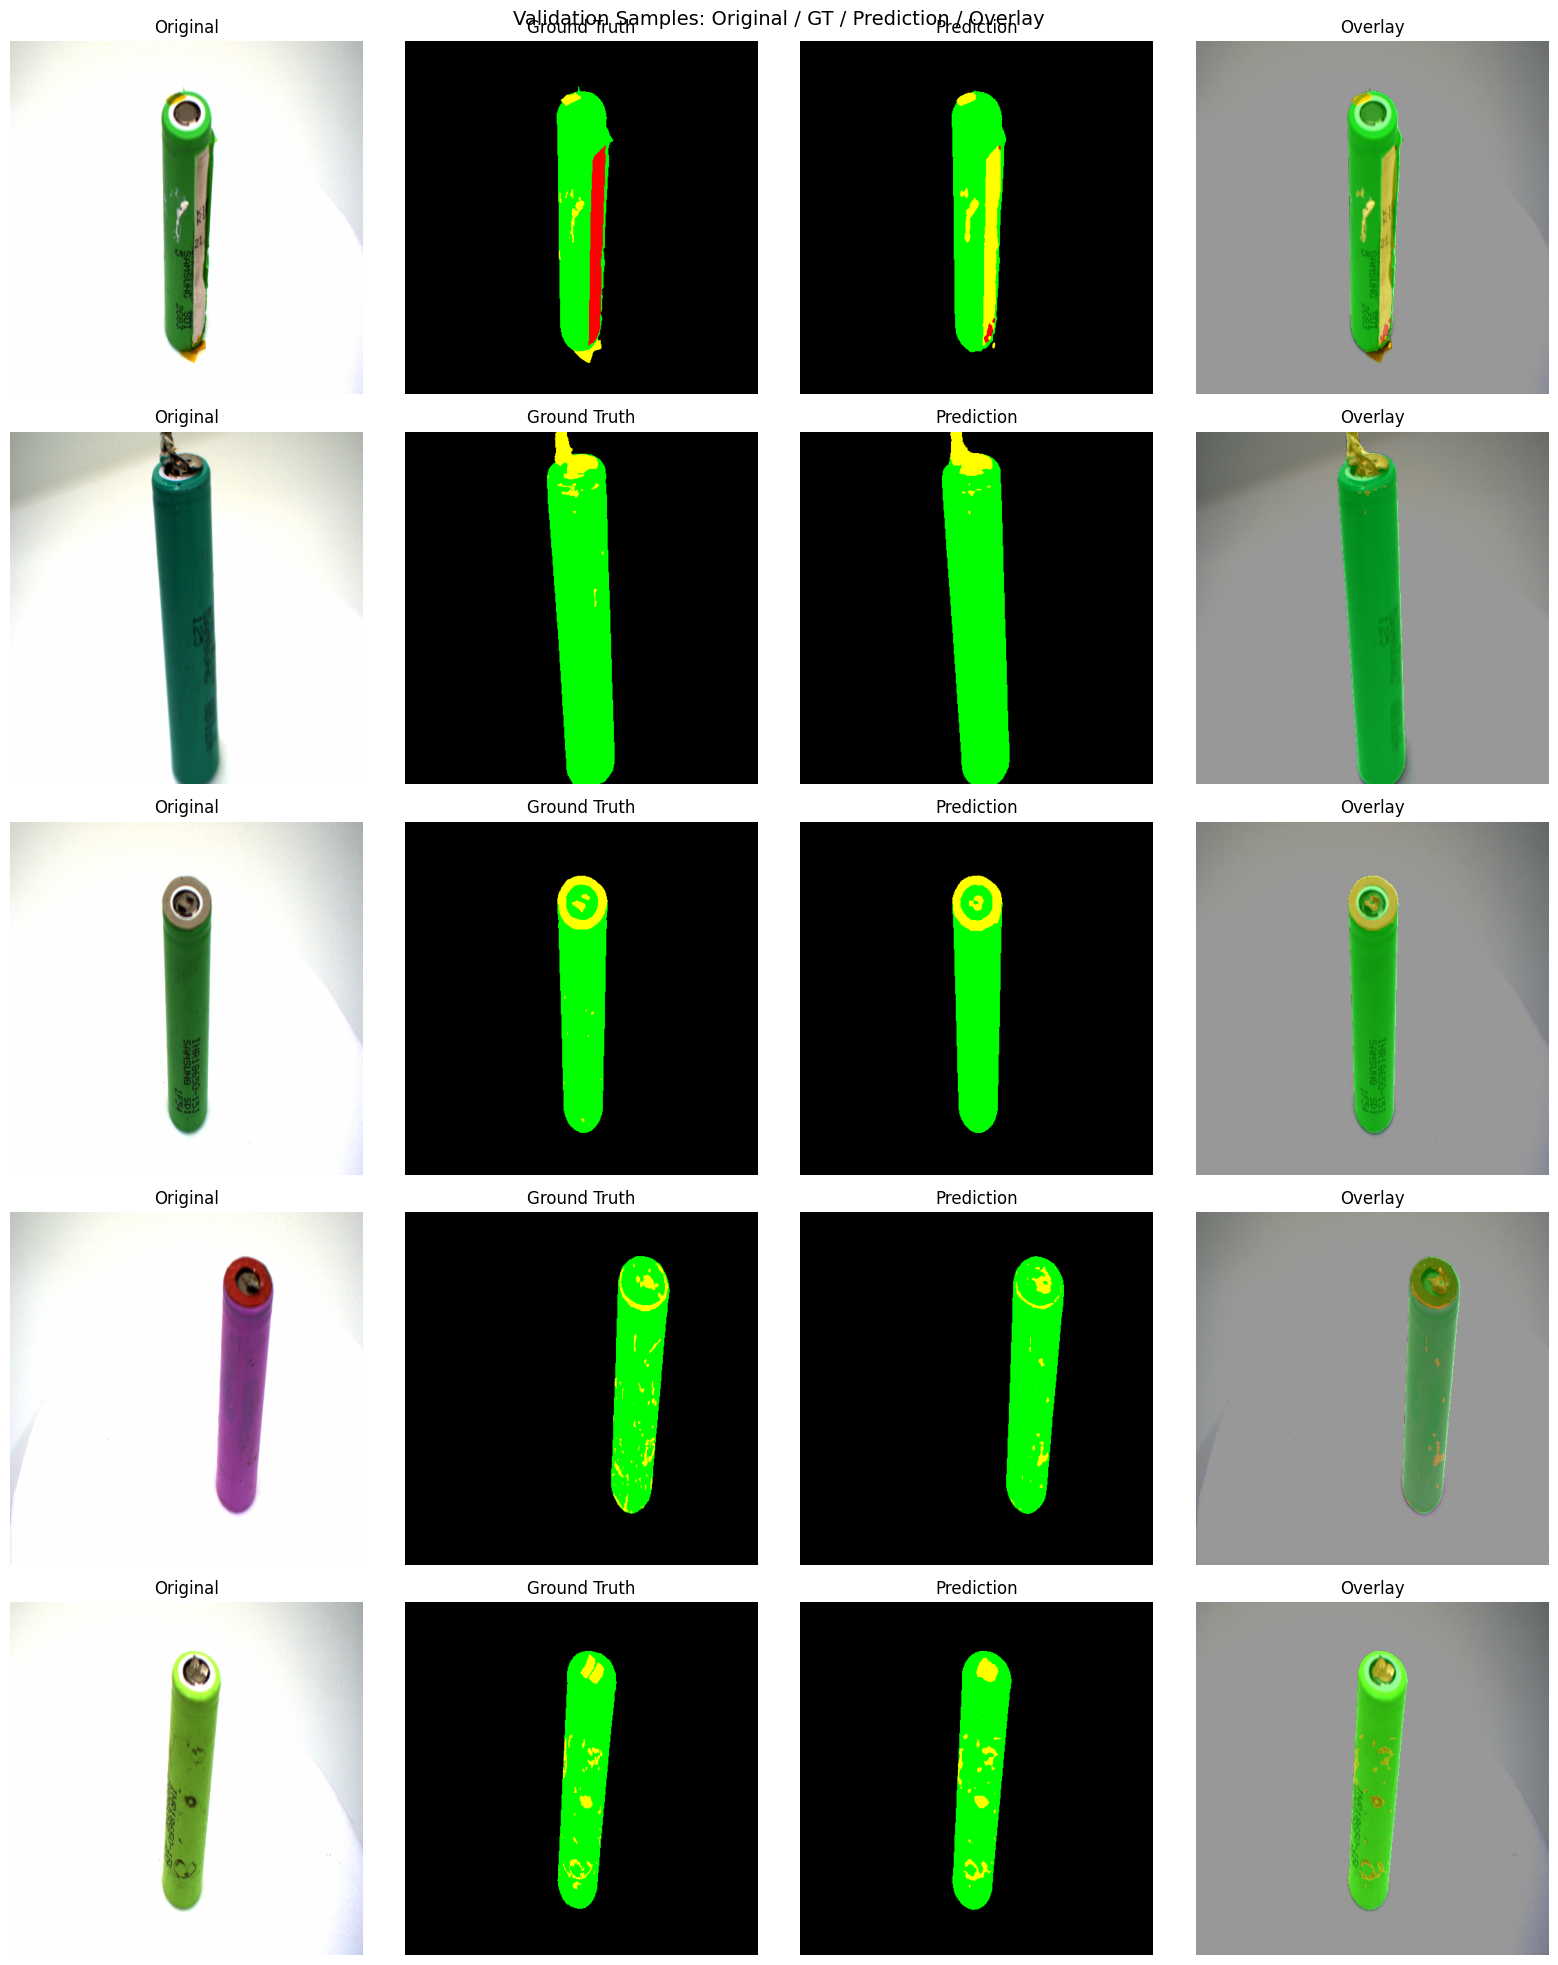

✅ 샘플 예측 저장: /content/drive/MyDrive/MyDataset/sample_predictions.png


In [ ]:
# 컬러맵 정의
COLORS = {
    0: [0, 0, 0],        # Background: 검정
    1: [255, 255, 0],    # Pollution: 노랑
    2: [255, 0, 0],      # Damaged: 빨강
    3: [0, 255, 0]       # Outline: 초록
}

def mask_to_color(mask):
    """마스크를 컬러 이미지로 변환"""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in COLORS.items():
        color_mask[mask == cls] = color
    return color_mask

def denormalize(img):
    """정규화 해제"""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    return np.clip(img, 0, 1)

# 샘플 5개 시각화
fig, axes = plt.subplots(5, 4, figsize=(16, 20))

model.eval()
with torch.no_grad():
    for i in range(5):
        # 데이터 로드
        image, mask = val_dataset[i * 100]  # 간격 두고 샘플링

        # 예측
        output = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1).cpu().numpy()[0]

        # 이미지 변환
        img_np = image.numpy().transpose(1, 2, 0)
        img_np = denormalize(img_np)
        mask_np = mask.numpy()

        # 시각화
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_to_color(mask_np))
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(mask_to_color(pred))
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')

        # 오버레이
        overlay = (img_np * 255).astype(np.uint8)
        pred_color = mask_to_color(pred)
        blended = cv2.addWeighted(overlay, 0.6, pred_color, 0.4, 0)
        axes[i, 3].imshow(blended)
        axes[i, 3].set_title('Overlay')
        axes[i, 3].axis('off')

plt.suptitle('Validation Samples: Original / GT / Prediction / Overlay', fontsize=14)
plt.tight_layout()
plt.savefig(f'{save_path}/sample_predictions.png', dpi=150)
plt.show()
print(f"✅ 샘플 예측 저장: {save_path}/sample_predictions.png")

In [ ]:
import json

# History를 JSON으로 저장
history_save = {
    'train_loss': history['train_loss'],
    'val_loss': history['val_loss'],
    'miou': history['miou']
}

with open(f'{save_path}/training_history.json', 'w') as f:
    json.dump(history_save, f, indent=2)

print(f"✅ 학습 기록 저장: {save_path}/training_history.json")

✅ 학습 기록 저장: /content/drive/MyDrive/MyDataset/training_history.json


In [ ]:
print("\n📁 저장된 파일 목록:")
for f in os.listdir(save_path):
    file_path = os.path.join(save_path, f)
    size = os.path.getsize(file_path) / (1024*1024)  # MB
    print(f"   {f} ({size:.2f} MB)")


📁 저장된 파일 목록:
   val_dataset.zip (7478.34 MB)
   train_dataset.zip (29839.93 MB)
   last_model.pth (18.20 MB)
   training_history.png (0.07 MB)
   evaluation_results.txt (0.00 MB)
   sample_predictions.png (1.84 MB)
   training_history.json (0.00 MB)
   best_model.pth (18.20 MB)
   checkpoint.pth (54.30 MB)
